In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [77]:
movie_df = pd.read_csv('./movie/movie_1980_2025.csv')
movie_df['genres'] = movie_df['genres'].apply(ast.literal_eval)
movie_df['countries_origin'] = movie_df['countries_origin'].apply(ast.literal_eval)
display(movie_df[720:728])

movie_df.info()

,Title,Year,MPA,countries_origin,genres,Duration_minute
720,121. My Dinner with Andre,1981,PG,[United States],"[Comedy, Drama]",110.0
721,122. The Boat Is Full,1981,PG,"[Switzerland, West Germany, Austria]","[Drama, War]",101.0
722,123. The Pit,1981,R,[Canada],"[Horror, Mystery]",96.0
723,124. The Woman Next Door,1981,R,[France],"[Tragic Romance, Drama, Romance]",106.0
724,125. Christiane F.,1981,R,[West Germany],"[Biography, Drama]",138.0
725,126. Southern Comfort,1981,R,[United States],"[Psychological Thriller, Action, Thriller]",106.0
726,127. Galaxy of Terror,1981,R,[United States],"[Space Sci-Fi, Action, Adventure, Horror, Sci-Fi]",81.0
727,128. Beau-père,1981,13+,[France],"[Comedy, Drama, Romance]",123.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             27550 non-null  object 
 1   Year              27550 non-null  int64  
 2   MPA               27550 non-null  object 
 3   countries_origin  27550 non-null  object 
 4   genres            27550 non-null  object 
 5   Duration_minute   27550 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ MB


## 전체 평균 러닝타임 (이상치 제거) **

/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/4059027799.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


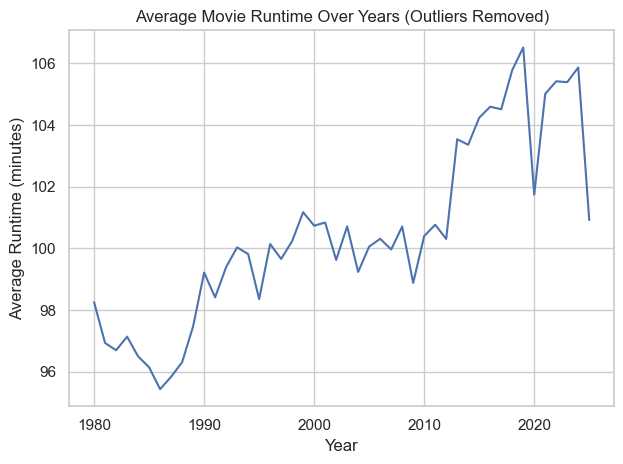

In [ ]:
# IOR 밖 이상치 제거 helper 함수
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# 연도별로 이상치 제거
filtered_df = movie_df[movie_df['Duration_minute'].notna()]
filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# 연도별 평균 상영시간
avg_movie_runtime_df = filtered_df.groupby('Year').agg(
    avg_runtime=('Duration_minute', 'mean')
).reset_index()

sns.lineplot(data=avg_movie_runtime_df, x="Year", y="avg_runtime")
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.title('Average Movie Runtime Over Years (Outliers Removed)')
plt.grid(True)
plt.tight_layout()
plt.show()

우상향 그래프인 것을 볼 수 있음

## 추세선 **

<Axes: xlabel='Year', ylabel='avg_runtime'>

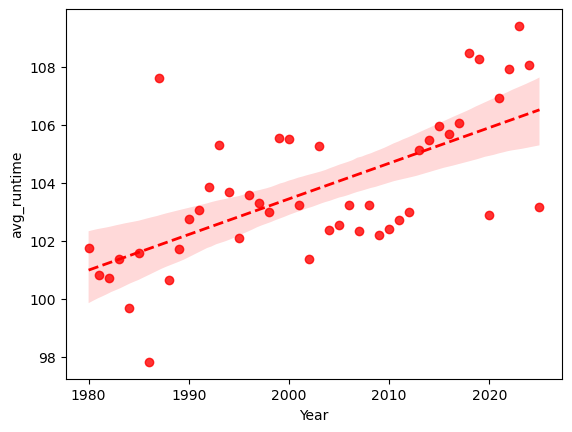

In [79]:
sns.regplot(data=avg_movie_runtime_df, x='Year',y='avg_runtime' ,scatter=True, color='red', line_kws={'linestyle': '--', 'linewidth': 2})

우상향하는 추세선을 볼 수 있음

## 장르별 상영시간 (탑 5개 장르) **

/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/4007040967.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_df_cleaned = genre_df.groupby('genres', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


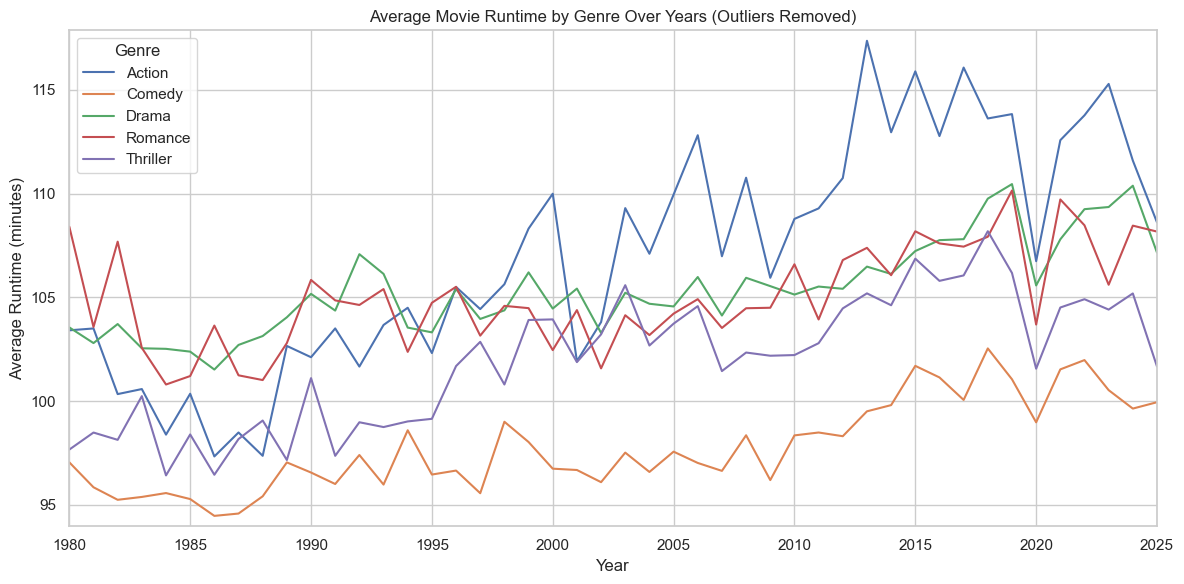

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Explode genres ---
genre_df = movie_df.explode('genres')

# --- Step 2: Remove outliers within each genre using IQR ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

genre_df_cleaned = genre_df.groupby('genres', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# --- Step 3: Group by year and genre, then compute average ---
genre_year_avg = (
    genre_df_cleaned.groupby(['Year', 'genres'])['Duration_minute']
    .mean()
    .reset_index()
    .rename(columns={'genres': 'Genre', 'Duration_minute': 'avg_runtime'})
)

# --- Step 4: Select top 5 genres by frequency ---
top_genres = genre_df['genres'].value_counts().head(5).index
filtered_df = genre_year_avg[genre_year_avg['Genre'].isin(top_genres)]

# --- Step 5: Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='Year', y='avg_runtime', hue='Genre')
plt.title('Average Movie Runtime by Genre Over Years (Outliers Removed)')
plt.xlabel('Year')
plt.xlim(1980, 2025)
plt.ylim(filtered_df['avg_runtime'].min() -0.5, filtered_df['avg_runtime'].max()+0.5)
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 장르별 추세선

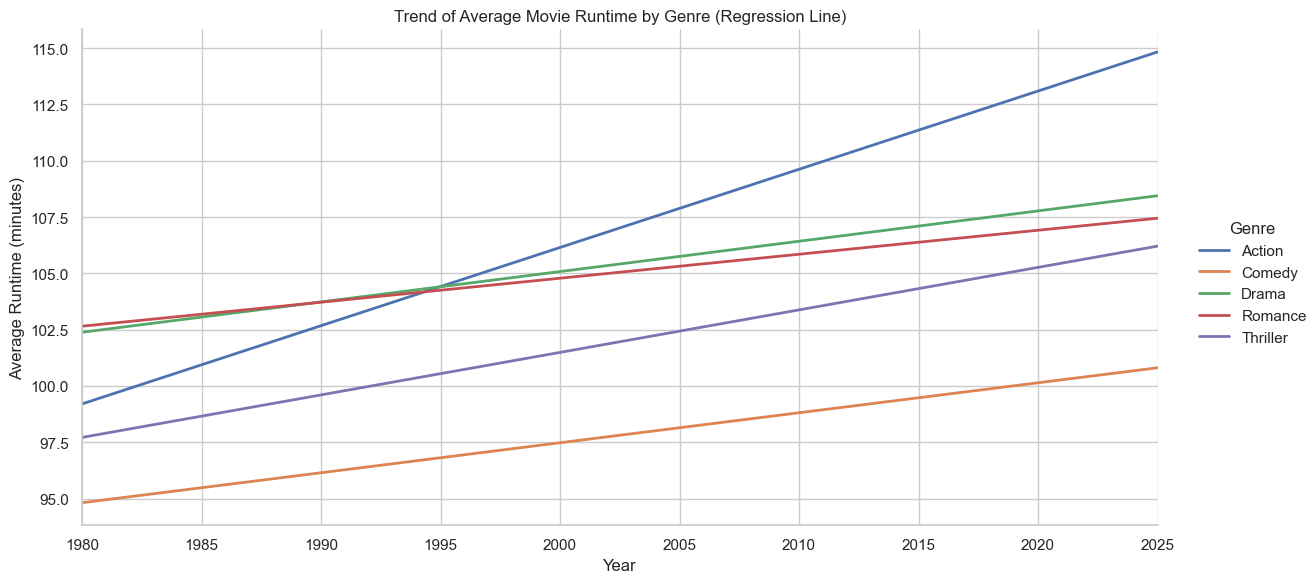

In [114]:
# Reuse the 'filtered_df' from previous step
# filtered_df contains Year, Genre, and avg_runtime after outlier removal

g = sns.lmplot(
    data=filtered_df,
    x='Year',
    y='avg_runtime',
    hue='Genre',
    height=6,
    aspect=1.8,
    ci=None,        
    scatter=False, 
    line_kws={'lw': 2}  
)
g._legend.set_bbox_to_anchor((1.1, 0.5))  # Place legend outside right
plt.title('Trend of Average Movie Runtime by Genre (Regression Line)')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.xlim(1980, 2025)
plt.grid(True)
plt.tight_layout()
plt.show()

전부 우상향

## 국가별 상영시간 (탑 5개 국가)

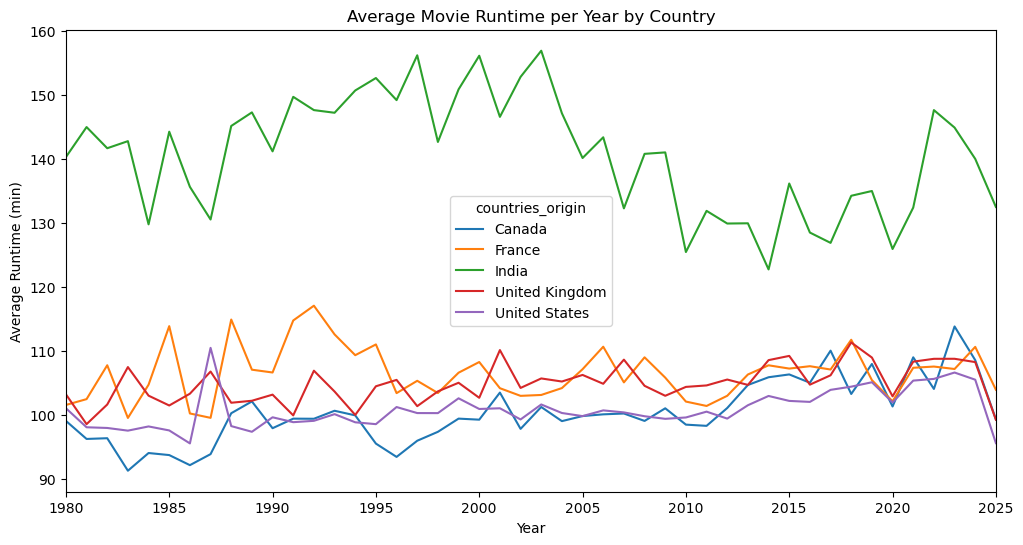

In [81]:
# 장르가 여러개인 영화의 장르들을 풀기
country_df = movie_df.explode('countries_origin')

# 연도와 장르로 그룹핑한 새 dataframe
avg_runtime_by_country_year = country_df.groupby(['countries_origin', 'Year'])['Duration_minute'].mean().reset_index()
avg_runtime_by_country_year.rename(columns={'Duration_minute': 'avg_runtime'}, inplace=True)


# 가장 많은 5개 장르 추출
top_countries = country_df['countries_origin'].value_counts().head(5).index

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_runtime_by_country_year[avg_runtime_by_country_year['countries_origin'].isin(top_countries)],
    x='Year',
    y='avg_runtime',
    hue='countries_origin'
)
plt.title("Average Movie Runtime per Year by Country")
plt.ylabel("Average Runtime (min)")
plt.xlim(1980,2025)
plt.show()

## 10년 단위 Box Plot (이상치 제외) **

/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/164354950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'decade'] = (filtered_df['Year'] // 10) * 10
/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/164354950.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1980s' '1980s' '1980s' ... '2020s' '2020s' '2020s']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.loc[:, 'decade'] = filtered_df['decade'].astype(str) + 's'


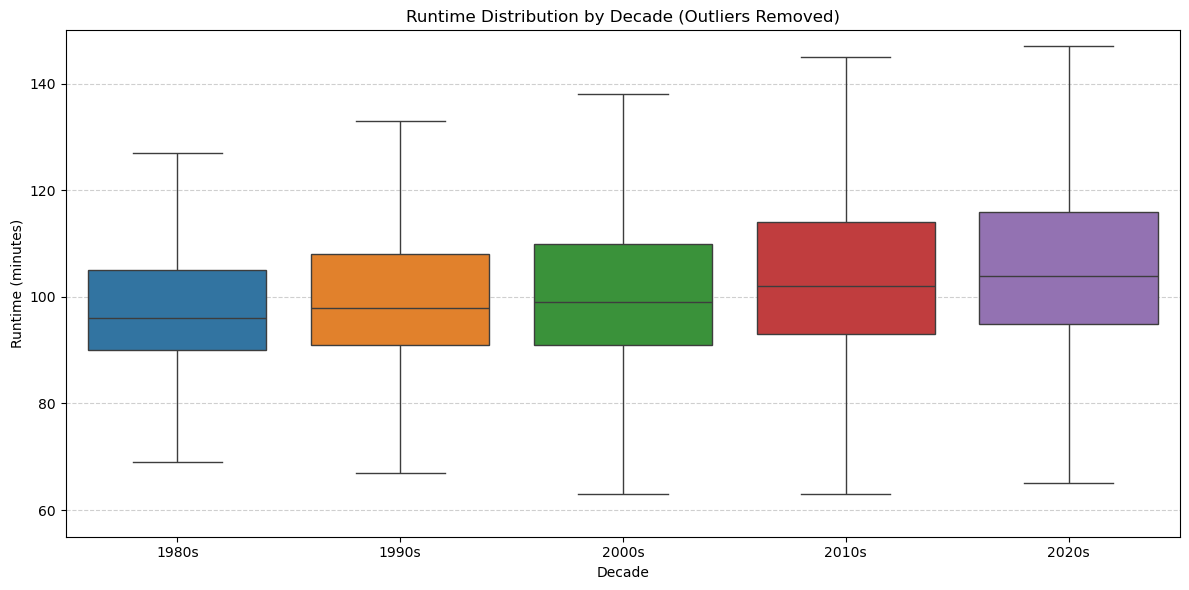

In [83]:
filtered_df.loc[:, 'decade'] = (filtered_df['Year'] // 10) * 10
filtered_df.loc[:, 'decade'] = filtered_df['decade'].astype(str) + 's'

# Plot
plt.figure(figsize=(12, 6))
#sns.boxplot(data=filtered_df, x='decade', y='Duration_minute', palette='Set2')
sns.boxplot(data=filtered_df, x='decade', y='Duration_minute', hue='decade', legend=False, showfliers= False)
plt.title('Runtime Distribution by Decade (Outliers Removed)')
plt.xlabel('Decade')
plt.ylabel('Runtime (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(55, 150)
plt.tight_layout()
plt.show()

- median 값이 점점 증가하는 것을 볼 수 있음
- IQR도 점점 위로 올라가는 것을 볼 수 있음

## 탑 5개 장르별 상영시간 분산

/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/1619667249.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_top10_df = top_10_df.groupby('genres', group_keys=False).apply(remove_outliers_iqr)
/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/1619667249.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_variance.values, y=genre_variance.index, palette='crest')


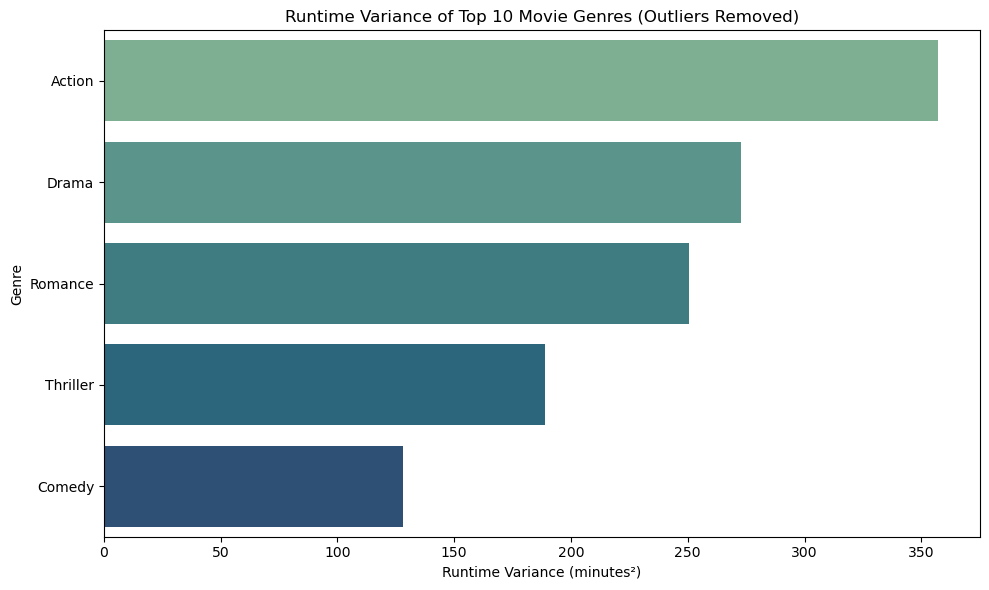

In [84]:
# Step 1: Explode genres (if not already)
genre_df = movie_df.copy()
#genre_df['genres'] = genre_df['genres'].apply(ast.literal_eval)
genre_df = genre_df.explode('genres')

# Step 2: Get Top 10 Genres
top_10_genres = genre_df['genres'].value_counts().head(5).index
top_10_df = genre_df[genre_df['genres'].isin(top_10_genres)]

# Step 3: Remove outliers within each genre
def remove_outliers_iqr(group):
    q1 = group['Duration_minute'].quantile(0.25)
    q3 = group['Duration_minute'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group['Duration_minute'] >= lower) & (group['Duration_minute'] <= upper)]

cleaned_top10_df = top_10_df.groupby('genres', group_keys=False).apply(remove_outliers_iqr)

# Step 4: Compute variance per genre
genre_variance = cleaned_top10_df.groupby('genres')['Duration_minute'].var().sort_values(ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_variance.values, y=genre_variance.index, palette='crest')
plt.title('Runtime Variance of Top 10 Movie Genres (Outliers Removed)')
plt.xlabel('Runtime Variance (minutes²)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

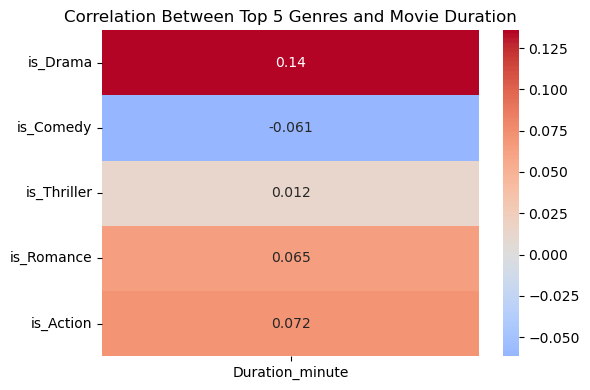

In [85]:
# Get top 5 genres by frequency
top_genres = genre_df['genres'].value_counts().head(5).index

# One-hot encode top genres
for genre in top_genres:
    movie_df[f'is_{genre}'] = movie_df['genres'].apply(lambda lst: genre in lst)

# Correlation matrix
columns_to_corr = [f'is_{genre}' for genre in top_genres] + ['Duration_minute']
corr_matrix = movie_df[columns_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix[['Duration_minute']].drop('Duration_minute'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Top 5 Genres and Movie Duration')
plt.tight_layout()
plt.show()

장르랑 상영시간이랑 상관성은 없어보임

## 상영등급 별 상영시간 (탑 5개 상영등급, 이상치 제거) **

/var/folders/mz/fktgp6vj62l5dw84vjcg4zj40000gn/T/ipykernel_14505/2381267370.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = top_mpa_df.groupby('MPA', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


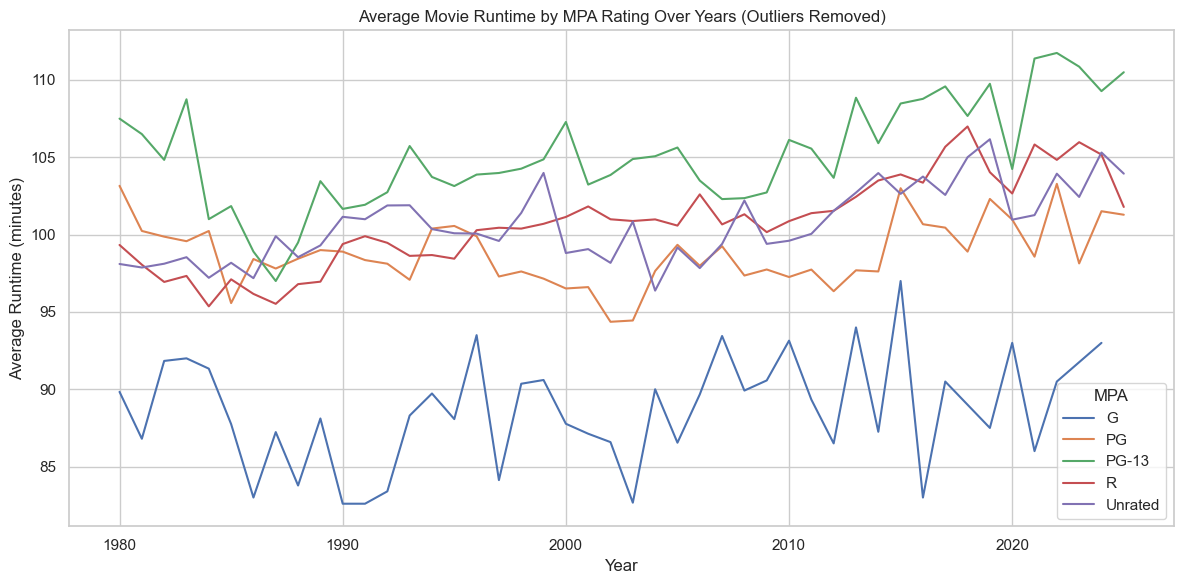

In [99]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# 탑5 등급
top_mpa = movie_df['MPA'].value_counts().head(5).index

# Filter for top 5 MPA
top_mpa_df = movie_df[movie_df['MPA'].isin(top_mpa) & movie_df['Duration_minute'].notna()]

# Apply outlier removal by MPA group
filtered_df = top_mpa_df.groupby('MPA', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# Group by Year and MPA to get average duration
mpa_avg_by_year = (
    filtered_df.groupby(['Year', 'MPA'])['Duration_minute']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=mpa_avg_by_year, x='Year', y='Duration_minute', hue='MPA')
plt.title('Average Movie Runtime by MPA Rating Over Years (Outliers Removed)')
plt.ylabel('Average Runtime (minutes)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()

## 상영등급별 (top 5, 이상치 제거) 추세

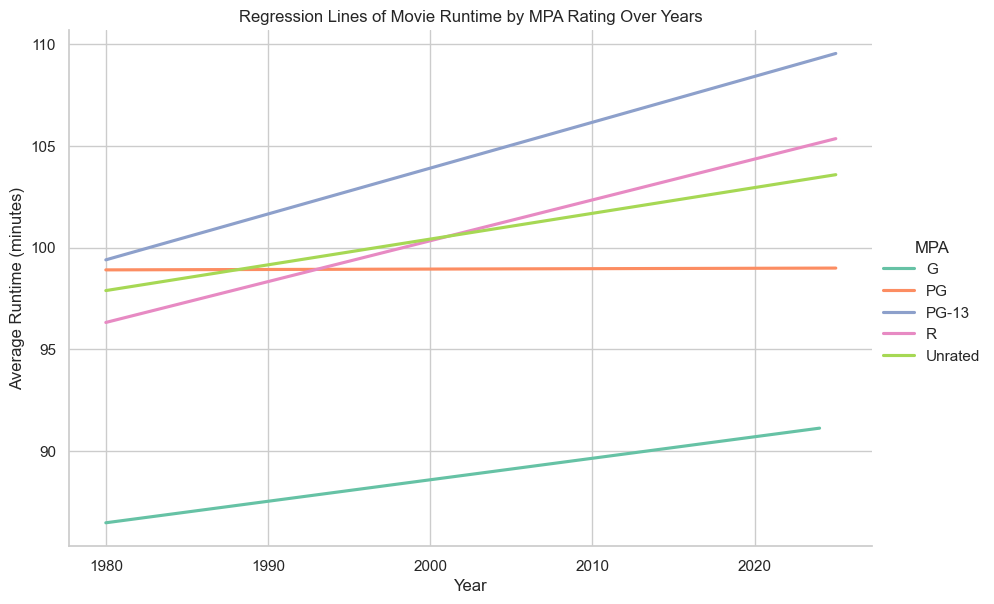

In [102]:
sns.lmplot(
    data=filtered_df,       
    x='Year', 
    y='Duration_minute', 
    hue='MPA',              
    height=6, 
    aspect=1.5, 
    markers='o',
    ci=None,                # turn off confidence interval if you prefer a cleaner look
    scatter=False,          # remove scatter dots for cleaner regression-only view
    palette='Set2'
)

plt.title('Regression Lines of Movie Runtime by MPA Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.show()